<a href="https://colab.research.google.com/github/petrasuk/CADL/blob/master/TryingToWorkWithTwoNetworks(Working).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2018 The TensorFlow Datasets Authors, Licensed under the Apache License, Version 2.0

In [0]:
!pip install -q tensorflow-datasets tensorflow

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds


import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

# tfds works in both Eager and Graph modes
tf.enable_v2_behavior()

# Construct a tf.data.Dataset
ds = tfds.load('mnist', split='train', shuffle_files=True)

# Build your input pipeline
ds = ds.shuffle(1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
k=0
for example in ds.take(10):
  k=k+1
  print(k)
  image, label = example['image'], example['label']

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4


    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})> could not be transformed and will be executed as-is. Please report this to the AutoGraph team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output. Cause: Bad argument number for Name: 3, expecting 4
1
2
3
4
5
6
7
8
9
10


    8192/11490434 [..............................] - ETA: 0s

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
(10000,)
(10000, 28, 28)


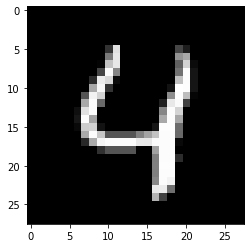

In [0]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print(test_labels.shape)
print(test_images.shape)
plt.imshow(test_images[4,:, :].astype(np.float32), cmap=plt.get_cmap("gray"))

(28, 28)
Label: 7
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


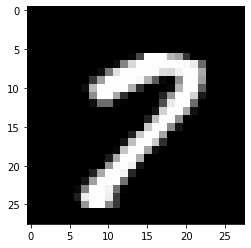

In [0]:
for example in ds.take(1):
  image, label = example['image'], example['label']
  label2 = tf.one_hot(label,10)
  im_np = image.numpy()
  im_np2 = im_np[0,:,:,0]
  print(im_np2.shape)
  plt.imshow(image.numpy()[0,:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))
  print("Label: %d" % label[0].numpy())
  print(label2[0].numpy())

In [0]:
print(image.shape)
print(label.shape)

(32, 28, 28, 1)
(32,)


In [0]:
def make_a():
    inputs = tf.keras.layers.Input(shape=[28,28,1])
    model = tf.keras.Sequential()
    model.add(inputs)
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(128, activation='relu'))

    return model

In [0]:
def make_b():
    inputs = tf.keras.layers.Input(shape=[128,])
    model = tf.keras.Sequential()
    model.add(inputs)
    model.add(layers.Dense(10,activation='softmax'))

    return model

In [0]:
model_a = make_a()
model_b = make_b()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(1e-4)

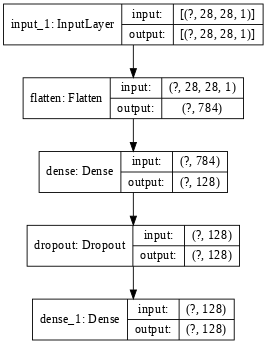

In [0]:
tf.keras.utils.plot_model(model_a, show_shapes=True, dpi=64)

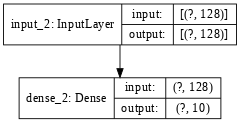

In [0]:
tf.keras.utils.plot_model(model_b, show_shapes=True, dpi=64)

In [0]:
def train_step(image, label):

    with tf.GradientTape(persistent=True) as gen_tape:
      model_a_output = model_a(image, training=True)
      print('Model_a_output shape: ', model_a_output.shape)
      model_b_output = model_b(model_a_output, training=True)
      print('Model_b_output shape: ', model_b_output.shape)
      loss = cross_entropy(model_b_output,label)
      
      print("Loss: ", loss)
      
    # gradients_of_model_a, gradients_of_model_b= gen_tape.gradient(loss, model_a.trainable_variables,model_b.trainable_variables)
    gradients_of_model_a = gen_tape.gradient(loss, model_a.trainable_variables)
    print('Gradients_of_model_a: ', gradients_of_model_a)
    gradients_of_model_b = gen_tape.gradient(loss, model_b.trainable_variables)
    print('Gradients_of_model_b: ', gradients_of_model_b)
    optimizer.apply_gradients(zip(gradients_of_model_a, model_a.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_model_b, model_b.trainable_variables))

In [0]:
epochs=10

In [0]:
def train(ds, epochs):
  for epoch in range(epochs):
    start = time.time()

    for example in ds.take(100):
      image, label = example['image'], example['label']
      label2 = tf.one_hot(label, depth=10)
      # print(label2.shape)
      # print(image.shape)
      train_step(image, label2)

In [0]:
train(ds, epochs)

Streaming output truncated to the last 5000 lines.
       -8.09496897e-32,  4.14553435e-28,  6.12435848e-32,  0.00000000e+00,
        3.12604056e-25, -7.51869492e-26, -2.55153782e-06,  0.00000000e+00,
        0.00000000e+00,  2.78600595e-07, -2.31310440e-31, -2.72416301e-25,
        3.14113220e-25,  6.77368158e-32, -8.43692942e-06,  0.00000000e+00,
        3.48747664e-27,  0.00000000e+00,  1.13586813e-27,  0.00000000e+00,
        3.05478743e-25,  4.82832365e-06,  3.23110056e-25,  0.00000000e+00,
       -3.64156949e-06,  2.78075857e-27, -2.01616651e-25, -2.08504252e-06,
        4.02861850e-31,  0.00000000e+00, -2.37064269e-05, -7.42674183e-06,
       -6.32611045e-06,  0.00000000e+00,  0.00000000e+00, -2.67994938e-06,
        0.00000000e+00,  2.64494956e-05, -3.81407276e-27, -1.78149203e-05,
       -1.98485878e-27,  2.68884842e-25,  0.00000000e+00,  1.48257378e-42,
        3.34186589e-05,  2.32170169e-05,  6.68922395e-25, -1.45927042e-05,
       -4.09896444e-07,  3.25102374e-05, -3.44339

In [0]:
result = model_b(model_a(test_images))

In [0]:
print(result[4])

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(10,), dtype=float32)
